이미지 증강!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

gpu 환경 설정

In [2]:
torch.manual_seed(777)
IMAGE_SIZE = 128

device='cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
print(device)

cpu


cuda는 본인 시스템에 맞게 설정을 하고 사용하여야 하고, 아니면 코랩사용.
코랩 무료제공량이 예전같지는 않아.

In [3]:
original_datasets=ImageFolder(root='../data02/flower_photos',
                              transform=transforms.Compose([
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor() 
                              ]))

print(original_datasets)

Dataset ImageFolder
    Number of datapoints: 2313
    Root location: ../data02/flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


전체 이미지를 부른다.

In [4]:
original_loader=DataLoader(original_datasets, 
                           batch_size=2313,
                           shuffle=True,
                           drop_last=False,
                           num_workers=1) #데이터 로드시 사용할 병렬 프로세스 수


이미지 추출

1000개 미만이면 빨라. 패치를 256해서?
데이터가 만개이상이면 배치를 줘서 이미지와 레이블을 줘서 추출??? ㅇㅁㅇ??
컴퓨터가 특정 수치 미만이면 빨라??? ㅇㅁㅇ?? 탐탐 정리좀 해줘!

In [5]:
original_images, labels = next(iter(original_loader))
print(original_images.shape)

torch.Size([2313, 3, 128, 128])


In [6]:
X=original_images
Y=labels

폴더의 순서대로 인덱스를 만든다.

In [7]:
print(labels)

tensor([3, 0, 4,  ..., 4, 3, 2])


그림을 그려보자
트렌스폼 만들기

이미지를 키우고 256,256 하고
센터 크롭으로 128, 128로 크롭해라.

In [10]:
image_trasform = transforms.Compose([
  transforms.Resize((256, 256)), #이미지 크기를 2배로 만들겠다. 
  transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)), #실제 이미지가 다르면 안되니까? ㅇㅁㅇ?
  transforms.ToTensor() 
])

In [12]:
transform_dataset=ImageFolder(root='../data02/flower_photos',
                              transform=image_trasform) #트랜스폼에 방금 만든 이미지트렌스폼 넣어
transforms_loader=DataLoader(transform_dataset,
                             batch_size=1000, #1000개 뽑겠다
                             shuffle=True,
                             num_workers=1)

아래에 1000개 이하로 하니까 금방된다.
파이토치로 천개뽑으면 금방뽑아. 
이미지 추출 끝. 

In [13]:
transform_images, labels=next(iter(transforms_loader))

그림으로 그려보자.

In [14]:
def plot(x, y):
  plt.figure(figsize=(8,10))
  for i in range(len(x)):
    plt.subplot(5,5,i+1)
    plt.title(y[i].item()) #tensor니까 item
    plt.imshow(x[i].permute(1,2,0)) #텐서(chanel, row, col) 그림을 그릴때는 aray로 있어야해.:배열(row, col, channel)
    plt.axis('off')
  plt.show()

꽃을 배로 확대해서 크롭한거

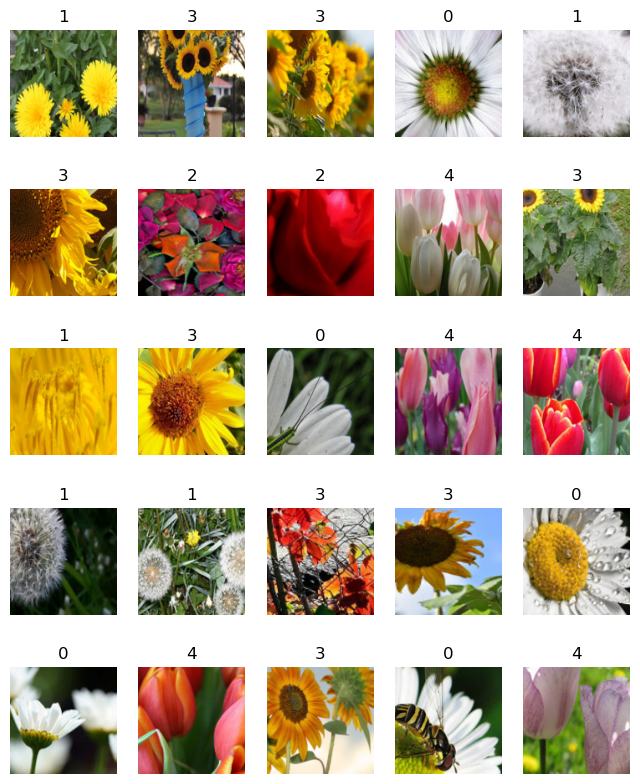

In [15]:
plot(transform_images[:25], labels[:25])

X, Y는 다 텐서야. 지금 만든것도 텐서로 만들어서 저장.

In [19]:
# print(X)
# print(Y)

print(transform_images.size(), labels.size())

torch.Size([1000, 3, 128, 128]) torch.Size([1000])


트렌스폼 이미지를 torch로 만들어서 붙힐거야.

print(transform_images.size(), labels.size()) 해보니 파이토치 텐서란거 확인.
잘못 더할수있으니 X1으로 만들고 더해보자, 더하니 천개가 증가됨.

In [20]:
X1=torch.cat([X, transform_images],dim=0)
Y1=torch.cat([Y, labels], dim=0)
print(X1.size(), Y1.size())

torch.Size([3313, 3, 128, 128]) torch.Size([3313])


하나하나하기 귀찮으니 함수를 만들어서 한번에 가자.
아래는 중요 코드!!!

빛의 증강

In [22]:
def create_loader(transform): #transform 하나를 보내겠다.
  transform_dataset=ImageFolder(root='../data02/flower_photos',
                                transform=transform)
  transforms_loader=DataLoader(transform_dataset,
                               batch_size=1000, #임의의 데이터 1000개 할떄마다 다른거
                               shuffle=True,
                               num_workers=1)
  
  transform_images, labels=next(iter(transforms_loader))

  #만약에 할때마다 이미지를 보고 싶다면.
  plot(transform_images[:25], labels[:25])

  #호출할떄마다 결과 볼수있어.

  return transform_images, labels

#transform만 보내주면 세트로 한번에 함.

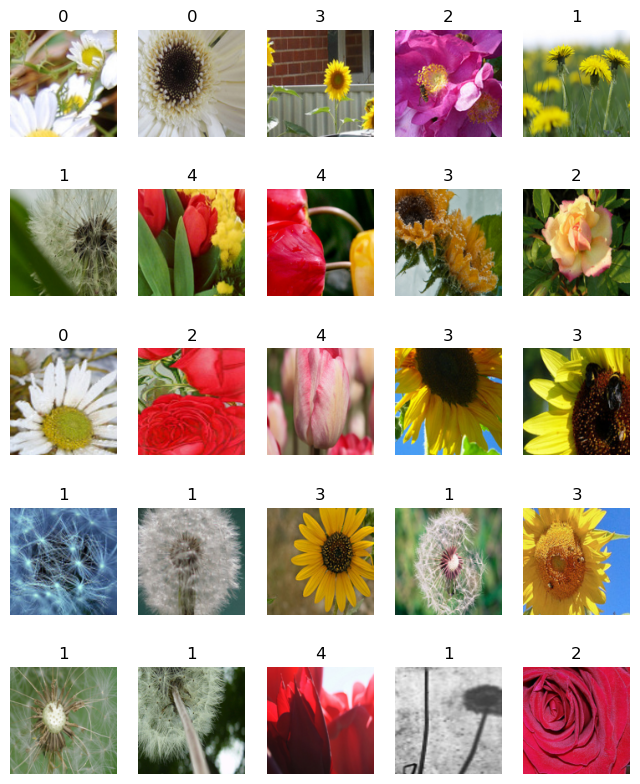

In [31]:
img_trasform=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

  #colorJitter 적용 /이미지 밝게 어둡게 색깔톤 변경
  transforms.ColorJitter(brightness=(0.9, 1.1), #밝기 왜곡 주의_색 범위테스트
                         contrast=(1,1),
                         saturation=(0.8, 1.0),
                          #  hue=(-0.2, 0.2)) #hue는 칼라에서 색 반전시키면 푸른색, 안해
                         ),
                         transforms.ToTensor()
                       
])
color_tf_images, color_th_labels = create_loader(image_trasform)

갯수가 늘어났다!

In [32]:
X2=torch.cat([X1, color_tf_images],dim=0)
Y2=torch.cat([Y1, color_th_labels],dim=0)

print(X2.size(), Y2.size())

torch.Size([4313, 3, 128, 128]) torch.Size([4313])


좌우 뒤집기

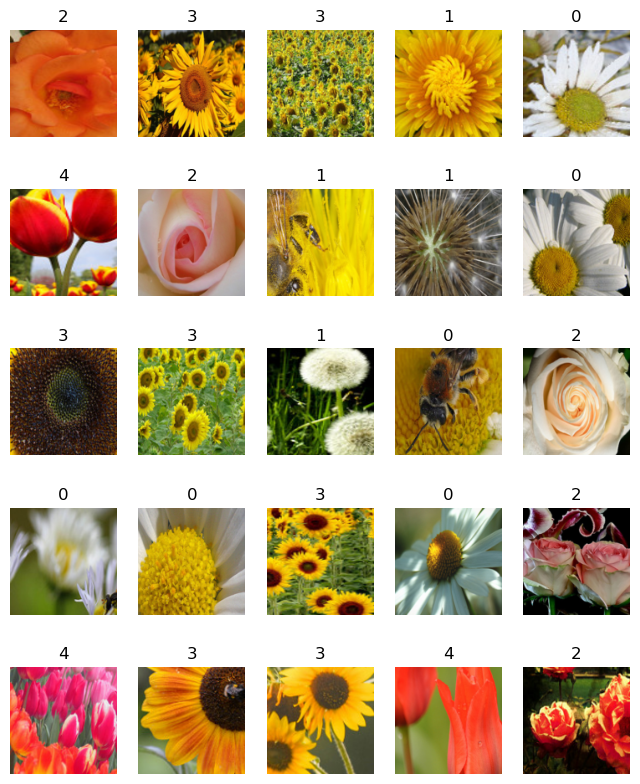

torch.Size([5313, 3, 128, 128]) torch.Size([5313])


In [33]:
img_trasform=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#RandomHorizontalFlip 적용
  transforms.RandomHorizontalFlip(p=0.8),
  transforms.ToTensor()                       
])

flip_tf_images, flip_tf_labels=create_loader(image_trasform)
X3=torch.cat([X2, flip_tf_images], dim=0)
Y3=torch.cat([Y2, flip_tf_labels], dim=0)
print(X3.size(), Y3.size())


원본 이미지에서 변형을 해서 사용을 하는 것이므로 불려서 분석을 하는 것.
저장을 하진 않아.
그래도 하는 사람은 있다-


오버피팅이 늦게 일어나면 많은 데이터를 인식할 수 있어서 유리하다.

이미지 증강에서 회전을 제일 많이 쓴다.

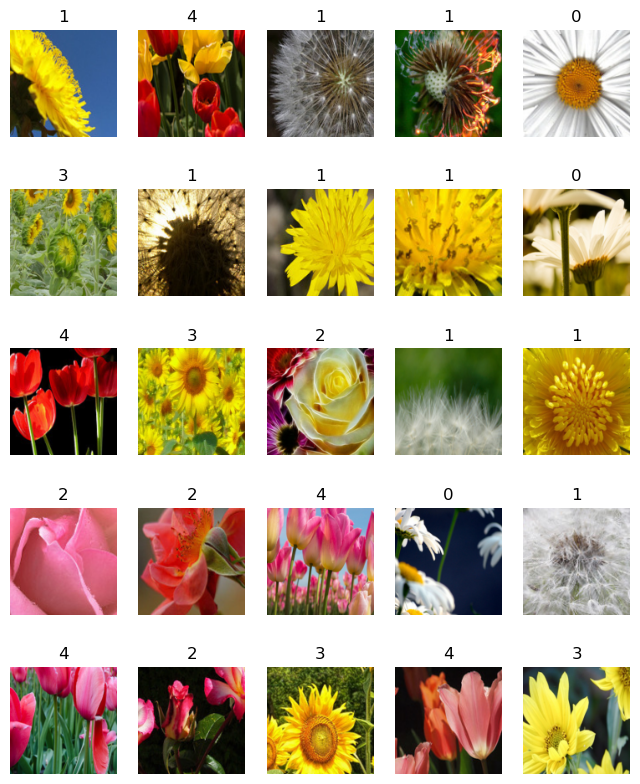

torch.Size([6313, 3, 128, 128]) torch.Size([6313])


In [34]:
img_trasform=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#RandomRotation 적용
  transforms.RandomRotation(degrees=(-15, 15),
                            interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
  transforms.ToTensor()                       
])

rot_tf_images, rot_tf_labels=create_loader(image_trasform)
X4=torch.cat([X3, rot_tf_images], dim=0)
Y4=torch.cat([Y3, rot_tf_labels], dim=0)
print(X4.size(), Y4.size())

이미지 블러처리, 날카롭게도 가능
근데 분석용 이미지라서 블러처리는 잘 안해.

(3,3) 를 뭉게서 블러 처리를 하는데 -> 특징 찾는데 도움이 안돼.
블러는 자잘한 노이즈를 없애는데 도움이 생겨.

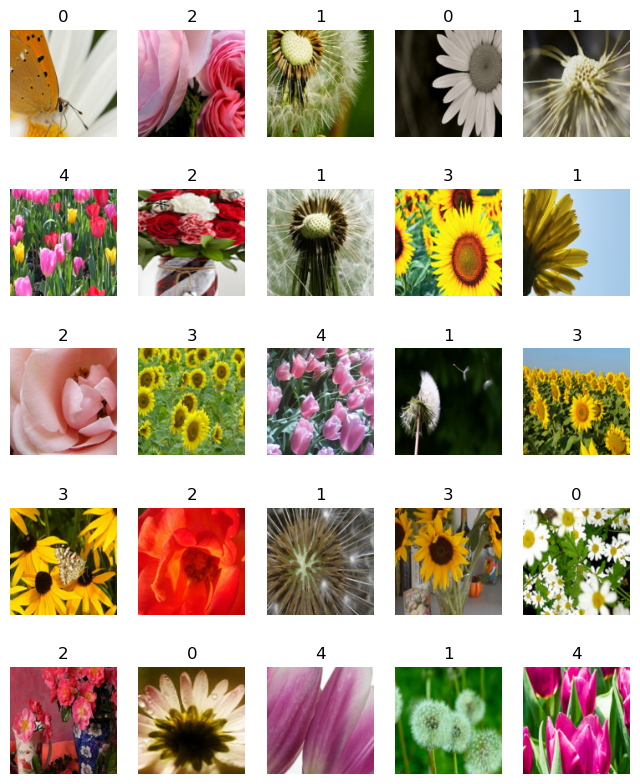

torch.Size([7313, 3, 128, 128]) torch.Size([7313])


In [35]:
img_trasform=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#GaussianBlur 적용
  transforms.GaussianBlur(kernel_size=(3, 3), sigma=(1.0, 2.0)),
  transforms.ToTensor()                       
])

GB_tf_images, GB_tf_labels=create_loader(image_trasform)
X5=torch.cat([X4, GB_tf_images], dim=0)
Y5=torch.cat([Y4, GB_tf_labels], dim=0)
print(X5.size(), Y5.size())

날카롭게!

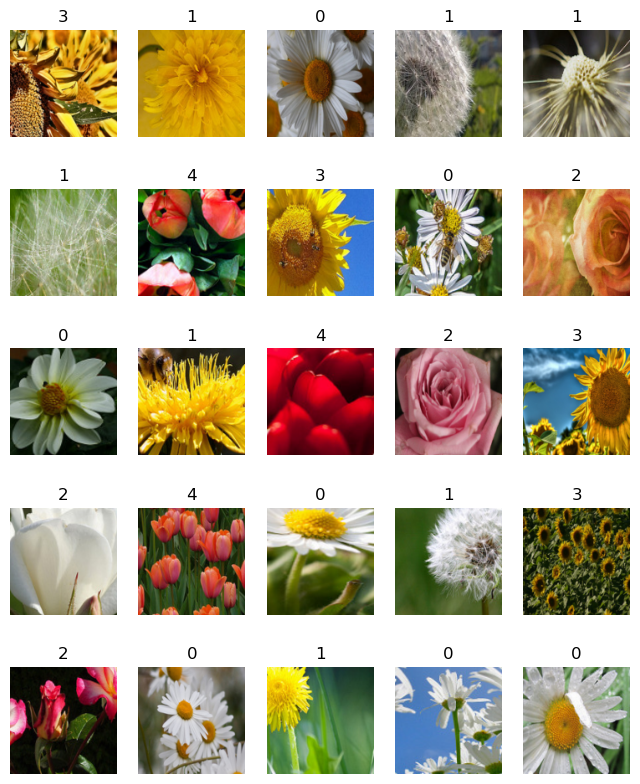

torch.Size([8313, 3, 128, 128]) torch.Size([8313])


In [36]:
img_trasform=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#RandomAdjustSharpness 적용
  transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.9),
  transforms.ToTensor()                       
])

sp_tf_images, sp_tf_labels=create_loader(image_trasform)
X6=torch.cat([X5, sp_tf_images], dim=0)
Y6=torch.cat([Y5, sp_tf_labels], dim=0)
print(X6.size(), Y6.size())

증강 완료! 어제한거 해보자!!
블러 빼고 할거야.

클래스는 5개야
해바라기나 민들레가 많으면, 가지고 올때 적게 가지고 와서 증강, 적은 거는 배치 사이즈를 늘여서 증강하면 비율 맞아

In [ ]:
cnt0=(Y4==0).sum()
cnt1=(Y4==1).sum()
cnt2=(Y4==2).sum()
cnt3=(Y4==3).sum()
cnt4=(Y4==4).sum()

print(cnt0, cnt1, cnt2, cnt3, cnt4)



tensor(1096) tensor(1567) tensor(1137) tensor(1434) tensor(1079)


In [40]:
ratio=[0.8, 0.2]
train_cnt=int(X4.size(0)*ratio[0])
test_cnt=int(X4.size(0)*ratio[1])

cnts=[train_cnt, test_cnt]
print("Train %d / Test %d samples." % (train_cnt, test_cnt))

Train 5050 / Test 1262 samples.


In [41]:
Y4

tensor([3, 0, 4,  ..., 2, 3, 4])

덧붙힌거니까 원래 데이터와 증강한거를 섞어줘야해. 고르게 나오니까.

In [42]:
indices=torch.randperm(X4.size(0))
indices


tensor([2156, 6257, 1091,  ..., 5920, 1921, 1995])

섞어놓은대로 인덱스도 맞춰줘.

In [43]:
x=torch.index_select(X4, dim=0, index=indices)
y=torch.index_select(Y4, dim=0, index=indices)

In [44]:
x_train=x[:cnts[0]]
x_test=x[cnts[0]:]

y_train=y[:cnts[0]] #0부터 시작해서 cnts 전까지
y_test=y[cnts[0]:] #cnts에서 끝까지

print(x_train.size(), y_train.size())
print(x_test.size(), y_test.size())

torch.Size([5050, 3, 128, 128]) torch.Size([5050])
torch.Size([1263, 3, 128, 128]) torch.Size([1263])


데이터 셋이 지금까지는 폴더에 있거나, 데이터셋을 불러오거나 했는데
지금은 텐서로 x,y 데이터를 만든거고 데이터 셋으로 만들어줘야해.

In [45]:
train_dataset=TensorDataset(x_train, y_train)
test_dataset=TensorDataset(x_test, y_test)

데이터 로드해서 배치사이즈 주고 돌리는게 편했음.

In [46]:
train_loader=DataLoader(train_dataset,
                        batch_size=100,
                        shuffle=True)

test_loader=DataLoader(test_dataset,
                        batch_size=100,
                        shuffle=True) #꼭 true 할 필요는 없다. 그럼에도 한다!

cnn 모델 어제 그대로 해도 괜찮은데(컨볼루젼, fc~ 각각 정의해도)
이번에는 이닛으로 레이어 불러서 사용하는 형태

파이썬은 super 함수로 불러야해.
super(CNN, self) 이건 생략가능.CNN, self

 nn.Conv2d(3, 8, 3, padding=1), #칼라니까 3 in_channels= 써도 됨, 출력 8 채널을 랜덤하게 8개, 3?

In [53]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__() 

    self.layer1= nn.Sequential(
      nn.Conv2d(3, 8, 3, padding=1), 
      nn.ReLU(),
      # nn.Dropout(0.25), 딥러닝 선의 25% 날려. 오버피팅 방지
      # nn.BatchNorm2d() 정규화도 가능, 1D든 2D든
      nn.MaxPool2d(kernel_size=2, stride=2) # 64*64
    )

    self.layer2= nn.Sequential(
      nn.Conv2d(8, 16, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 32*32
    )

    self.layer3= nn.Sequential(
      nn.Conv2d(16, 32, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) #16*16
    )

    self.layer4= nn.Sequential(
      nn.Conv2d(32, 64, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) #64*8*8
    )

    self.layer5= nn.Sequential(
      nn.Conv2d(64, 128, 3, padding=1), 
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 128*4*4 만큼 특징이 있다.
    )    

    #완전 연결층

    self.fc1=nn.Linear(128*4*4, 128) #128은 내 맘대로, 은닉층의 수는 모델개발자가 선택
    self.fc2=nn.Linear(128, 64)
    self.fc3=nn.Linear(64,5)

  def forward(self, x): #파이썬의 함수는 항상 self가 들어온다
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)
    x=self.layer5(x)

    #컨볼루션 층 끝!

#3차원 이미지
    x=x.view(-1, 128*4*4)
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)
#소프트맥스에 넣어줘야하지만 crossentropy에 넣을 거라서 바로 리턴

    return x
      



모델을 사오거나 공개모델을 사서 써도 데이터를 만들 줄 알아야한다!

모델

In [68]:
model=CNN().to(device)
optimizer=optim.Adam(model.parameters()) #러닝메이트 안써도 됨. adam이 적응적 러닝메이트 함
crit=nn.CrossEntropyLoss().to(device)


훈련! 트레이닝 함수

In [69]:
def train(model, train_loader, optimizer, epoch):
  model.train() #train mode 로 설정

  for batch_index,(img, label) in enumerate(train_loader): #index를 하나 만들어줘
    img = img.to(device) #cuda
    label=label.to(device)

    optimizer.zero_grad()
    y_hat=model(img) #model 결과 얻고
    loss=crit(y_hat, label) #결과와 라벨로 손실함수 구하고
    loss.backward()
    optimizer.step() #wb를 업데이트

    if batch_index%10==0: #100개씩 데이터를 한번 읽을때, 10번마다 찍어
      print(f'train index/epoch:{batch_index,epoch}, train Loss:{loss.item()}') 


트레이닝이랑 검정을 같이하는 모델임
평가함수

drop out이나 정규화 하고 싶으면
활성화함수 leRU 뒤에
      # nn.Dropout(0.25), 딥러닝 선의 25% 날려. 오버피팅 방지
      # nn.BatchNorm2d() 정규화도 가능, 1D든 2D든 골라서 세팅



In [70]:
def evaluate(model, test_loader):
  model.eval() #drop out 안써. 만약에 쓴다면 
  test_loss = 0
  correct = 0

  with torch.no_grad(): #손실함수 기울기 연산 금지
    for img, label in test_loader:
      img=img.to(device)
      label=label.to(device)
      y_hat=model(img)
      test_loss+=crit(y_hat, label).item() # test 손실함수를 구해서 같이 출력

      pred=y_hat.argmax(dim=-1) #한 행에 5개의 값이 나와. 가장 큰 값을 구해서 pred, 1을 하던 -1하던 상관 없어
      correct+=(pred==label).sum() #True 1 or False 0 sum하면 맞는 갯수가 구해짐
    
  test_loss=test_loss/len(test_loader.dataset)
  test_accuracy = correct/len(test_loader.dataset)*100 
  return test_loss, test_accuracy


계속 돌지마라!
eary stop

훈련한 모델을 아예 저장할 거라서 deepcopy가 필요없어.
bestmodel을 불러 쓰면 필요???????????????

In [71]:
from copy import deepcopy

epochs = 200
early_stop=10 #빨리 보려고 10한거고 실제로는 100 하면 됨
lowest_loss=np.inf
lowest_epoch=np.inf
best_model=None

path="../data02/model.pt" 

In [72]:
for epoch in range(epochs):
  train(model, train_loader, optimizer, epoch)

  test_loss, test_accuracy=evaluate(model, test_loader) 
  print(f'epoch:{epoch}, test loss:{test_loss}, test_accuracy:{test_accuracy}')
 
  #얼리스탑

  if test_loss < lowest_loss:
    lowest_loss=test_loss
    lowest_epoch=epoch #현재의 에폭
    best_model=deepcopy(model) #이 페이지에서 바로 쓸때, 불러써
    torch.save(model.state_dict(), path) #딴 파일에서 쓰고 싶으면 저장

  else:
    if early_stop >0 and lowest_epoch + early_stop<epoch: #테스트의 최소cost를 
      print(f'{lowest_epoch} 이후에 {early_stop} 증가되는 동안 손실함수 감소가 없음')
      break

print(f'{lowest_epoch}일 때 손실함수의 값이 {lowest_loss}로 가장 낮음')

train index/epoch:(0, 0), train Loss:1.608363151550293
train index/epoch:(10, 0), train Loss:1.601833462715149
train index/epoch:(20, 0), train Loss:1.2802932262420654
train index/epoch:(30, 0), train Loss:1.2435473203659058
train index/epoch:(40, 0), train Loss:1.2807365655899048
train index/epoch:(50, 0), train Loss:1.2219300270080566
epoch:0, test loss:0.012739511302606699, test_accuracy:39.98416519165039
train index/epoch:(0, 1), train Loss:1.3040438890457153
train index/epoch:(10, 1), train Loss:1.1905443668365479
train index/epoch:(20, 1), train Loss:1.3477946519851685
train index/epoch:(30, 1), train Loss:1.1072102785110474
train index/epoch:(40, 1), train Loss:1.3110699653625488
train index/epoch:(50, 1), train Loss:1.216969609260559
epoch:1, test loss:0.013013185533567355, test_accuracy:42.042755126953125
train index/epoch:(0, 2), train Loss:1.2473149299621582
train index/epoch:(10, 2), train Loss:1.152732491493225
train index/epoch:(20, 2), train Loss:1.205054759979248
train 

정확도 보다 손실함수 기준으로 한다.
test 데이터니까.

다른데 쓰려면 CNN을 클레스로 만들어서 따로 불러써

model2는 cnn을 기준으로 만들겠습니다.
가중치 된건 지금 저장된거?

In [73]:
model2=CNN().to(device)
model2.load_state_dict(torch.load(path)) #path에 있는 모델이 손실함수 가장 작은 모델, 가지고 옴
model2.eval() #훈련용이 아니라 평가용이다. 


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

 100번 훈련을 2시간을 했어.
 새 데이터가 다시 들어왔다.
 다시 training 하면 현재상태에서 다시 트레이닝이 된거?????????ㅇㅁㅇ?????? 네?????????

In [ ]:
prediction=model2(x_test.to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction)
print(y_test)

tensor([4, 2, 0,  ..., 2, 3, 3])
tensor([4, 2, 0,  ..., 2, 3, 3])


% 확인
어제는 68%였는데 효율이 좋아짐.

In [75]:
arracy=(prediction==y_test).sum()
print(arracy/len(prediction))

tensor(0.8646)


In [76]:
prediction=model(x_test.to(device)).argmax(dim=-1) #1번 데이터를 훈련된 모델로 넣어보겠다.
print(prediction)

tensor([4, 2, 0,  ..., 4, 3, 3])


In [77]:
arracy=(prediction==y_test).sum()
print(arracy/len(prediction))

tensor(0.8614)
